## Experiments for the course project

In [26]:
from xgboost.sklearn import XGBClassifier
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, roc_curve, accuracy_score, recall_score, f1_score
from matplotlib import pyplot
from matplotlib.pyplot import figure
import numpy as np

In [2]:
x_train = pd.read_parquet('../dataset/labelencode_train.parquet')
x_test = pd.read_parquet('../dataset/labelencode_test.parquet')

In [3]:
cols = list(x_train.columns.values)
cols.remove('encounter_id')
cols.remove('diabetes_mellitus')

x_tr = x_train[cols].values
y_tr = x_train['diabetes_mellitus'].values
x_te = x_test[cols].values
y_te = x_test['diabetes_mellitus'].values

### Models
- best model (max_depth == 7)
- ## shorter max depth

In [4]:
best_params = {'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315,
 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}

In [5]:
def run_experiment(model_param, attrib, attrib_list):
    pos_outcomes = {}
    for att in attrib_list:
        model_param[attrib] = att
        print(model_param)
        model = XGBClassifier(**model_param)
        model.fit(x_tr, y_tr)
        y_pred = model.predict_proba(x_te)
        pos_outcomes[att] = y_pred.copy()#y_pred[:, 1].copy()
    return pos_outcomes

In [6]:
# pos_outcomes = run_experiment(best_params, 'max_depth', [i for i in range(1, 10, 2)])
pos_outcomes = run_experiment(best_params, 'max_depth', [7])

{'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}


/Users/grace/.pyenv/versions/3.7.2/envs/law_er/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [14]:
np.argmax(pos_outcomes[7], axis=1)

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
def draw_plot(outcomes, pos_prefix, title, file_name):
    # plot the roc curve for the model
    fig = figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

    rand_auc = [0 for _ in range(len(y_te))]
    ns_auc = roc_auc_score(y_te, rand_auc)
    print('Random: ROC AUC=%.3f' % (ns_auc))
    ns_fpr, ns_tpr, _ = roc_curve(y_te, rand_auc)
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--')

    for k, p in outcomes.items():
        # calculate scores    
        xgb_auc = roc_auc_score(y_te, p[:, 1])
        print('XGBoost %s: ROC AUC=%.3f' % (k, xgb_auc))
        acc = accuracy_score(y_te, np.argmax(p, axis=1))
        print("Accuracy %s: %.3f"% (k, acc))
        recall = recall_score(y_te, np.argmax(p, axis=1))#, average='micro')
        print("Recall %s: %.3f"% (k, recall))     
        f1 = f1_score(y_te, np.argmax(p, axis=1))#, average='micro')
        print("F1 %s: %.3f"% (k, f1))     
        
        xgb_fpr, xgb_tpr, _ = roc_curve(y_te, p[:, 1])
        pyplot.plot(xgb_fpr, xgb_tpr, label=pos_prefix+str(k))

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    pyplot.title(title)

    pyplot.show()
    fig.savefig(file_name)

Random: ROC AUC=0.500
XGBoost 7: ROC AUC=0.858
Accuracy 7: 0.840
Recall 7: 0.482
F1 7: 0.559


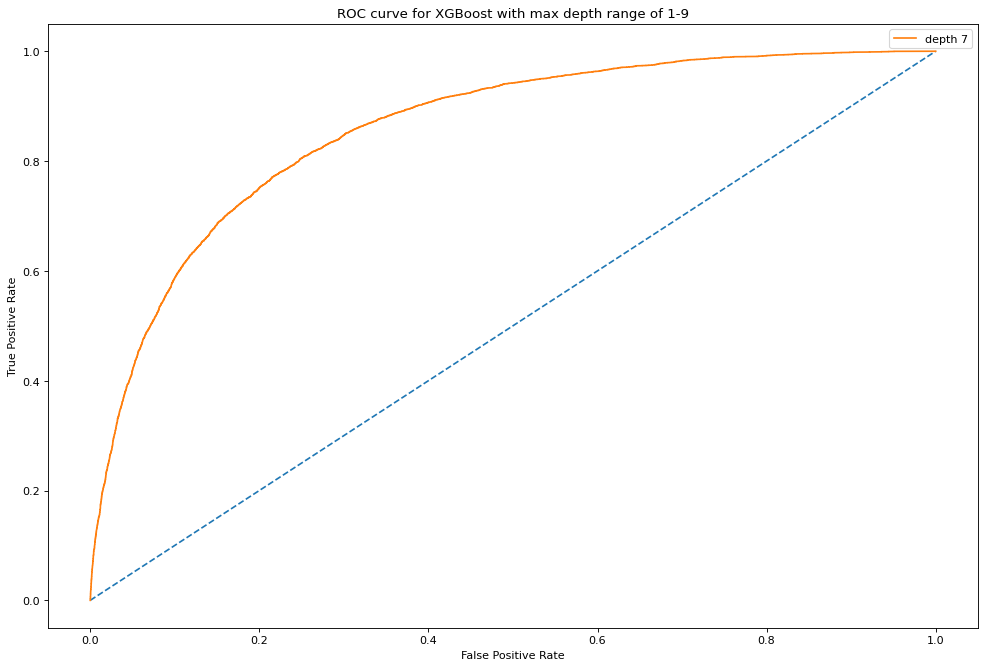

In [32]:
draw_plot(pos_outcomes, 'depth ', 'ROC curve for XGBoost with max depth range of 1-9', '../imgs/xgboost_labelencoding_depthvariations.png')

- ## learning rate

In [ ]:
best_params = {'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315,
 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
pos_outcomes = run_experiment(best_params, 'learning_rate', [0.001, 0.005, 0.01, 0.05, 0.1])

In [ ]:
draw_plot(pos_outcomes, 'learning_rate ', 'ROC curve for XGBoost with learning rate range', '../imgs/xgboost_labelencoding_lrvariations.png')

## n_estimators

In [ ]:
best_params = {'objective': 'binary:logistic', 'n_estimators': 230, 'min_child_weight': 0.9473684210526315,
 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.3157894736842105, 'booster': 'gbtree'}
pos_outcomes = run_experiment(best_params, 'n_estimators', [140, 170, 200, 230, 260])
draw_plot(pos_outcomes, 'n_estimators ', 'ROC curve for XGBoost with range of n_estimators', '../imgs/xgboost_labelencoding_nevariations.png')